The goal of this analysis is to identify different customer segments based on their purchasing behavior, allowing the business to tailor its marketing strategies and improve customer retention and sales.

**Steps to Perform RFM Analysis**
* Load and Prepare the Data
* Calculate RFM Metrics
* Assign RFM Scores
* Segment Customers Based on RFM Scores
* Interpret the Results

# Load the data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel(r"D:\Portfolio Github\customer_purchase_behavior\online_retail_II.xlsx", sheet_name = "Year 2009-2010" )
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Getting to know the variables:¶
* **InvoiceNo** : The number of the invoice, unique per each purchase. Refund invoice numbers contain "C"
* **StockCode** : Unique code per each item
* **Description** : Name of the item
* **Quantity** : The number of items within the invoice
* **InvoiceDate** : Date and time of the purchase
* **UnitPrice** : Price of a single item, as of Sterlin
* **CustomerID** : Unique id number per each customer
* **Country** : The country where the customer is living

In [3]:
df.shape

(525461, 8)

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

# Data Quality and Preparation:

* ### Are there any patterns in missing or inconsistent df that we should be aware of (e.g., missing customer IDs, negative quantities)?

In [5]:
# Check for rows with missing Customer ID
missing_customer_id = df[df['Customer ID'].isnull()]

#Check for rows with negative quantities
negative_quantities = df[df['Quantity'] < 0]

# Output the results
print("\nRows with Missing Customer ID:\n", missing_customer_id.shape)
print("\nRows with Negative Quantities:\n", negative_quantities.shape)


Rows with Missing Customer ID:
 (107927, 8)

Rows with Negative Quantities:
 (12326, 8)


In [6]:
# Separate rows with negative quantities
returns_data = df[df['Quantity'] < 0]
sales_data = df[df['Quantity'] >= 0]

# Check the results
print(f"Sales data shape (positive quantities): {sales_data.shape}")
print(f"Returns data shape (negative quantities): {returns_data.shape}")


Sales data shape (positive quantities): (513135, 8)
Returns data shape (negative quantities): (12326, 8)


In [7]:
# Create a new column 'Transaction Type' to indicate 'Return' or 'Sale'
df['Transaction Type'] = df['Quantity'].apply(lambda x: 'Return' if x < 0 else 'Sale')

# Convert all quantities to positive values
df['Quantity'] = df['Quantity'].abs()

In [8]:
# Handle missing values
# Drop rows with missing Customer ID since it's crucial for RFM analysis
df = df.dropna(subset=['Customer ID'])

# Fill missing values in other columns with appropriate methods (if necessary)
# For example, filling missing Description with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           417534 non-null  object        
 1   StockCode         417534 non-null  object        
 2   Description       417534 non-null  object        
 3   Quantity          417534 non-null  int64         
 4   InvoiceDate       417534 non-null  datetime64[ns]
 5   Price             417534 non-null  float64       
 6   Customer ID       417534 non-null  float64       
 7   Country           417534 non-null  object        
 8   Transaction Type  417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 31.9+ MB


In [10]:
# Convert Customer ID from float to string
df['Customer ID'] = df['Customer ID'].astype(str)

------------------------------

* ### Are there outliers (e.g., extremely high or low purchase amounts) that might skew the analysis?
    - Yes, there are 34,957 outliers in the dataset with extremely high or low purchase amounts, which could potentially skew the analysis.

In [11]:
# Calculate the total purchase amount for each row
df['Total Amount'] = df['Quantity'] * df['Price']

In [12]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Total Amount'].quantile(0.25)
Q3 = df['Total Amount'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [13]:
# Identify outliers
outliers = df[(df['Total Amount'] < lower_bound) | (df['Total Amount'] > upper_bound)]

# Check the result
print(f"Number of outliers: {outliers.shape[0]}")
print("Outliers in the data:\n", outliers[['Invoice', 'Quantity', 'Price', 'Total Amount']].head())

Number of outliers: 34957
Outliers in the data:
   Invoice  Quantity  Price  Total Amount
0  489434        12   6.95          83.4
1  489434        12   6.75          81.0
2  489434        12   6.75          81.0
3  489434        48   2.10         100.8
7  489434        10   5.95          59.5


---------------------------

* ### How does the data distribution look for key metrics like total sales, number of transactions?

In [14]:
# Calculate Number of Transactions
number_of_transactions = df['Invoice'].nunique()

In [15]:
# Aggregate Total Sales by Customer
total_sales_by_customer = df.groupby('Customer ID')['Total Amount'].sum()

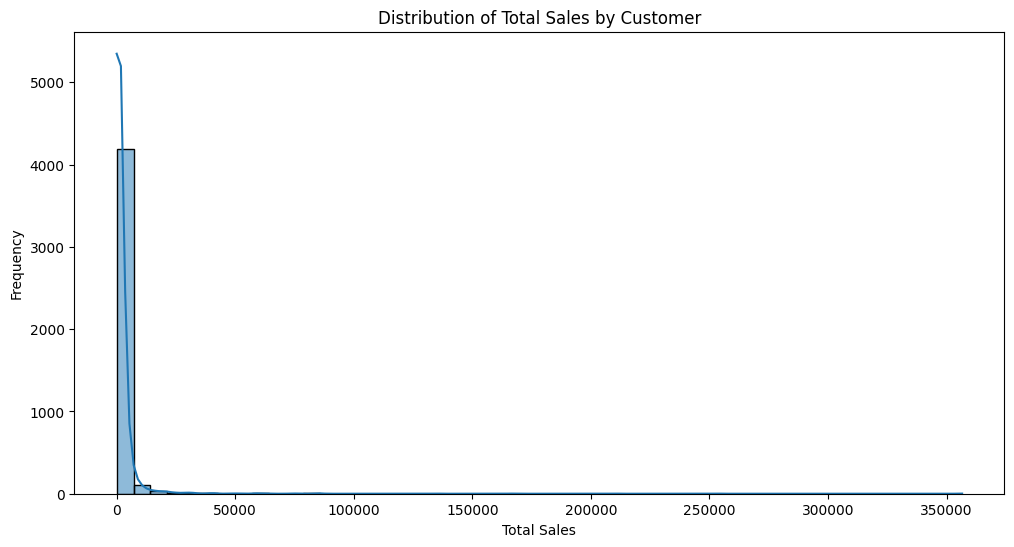

In [16]:
# Plot Total Sales Distribution
plt.figure(figsize=(12, 6))
sns.histplot(total_sales_by_customer, bins=50, kde=True)
plt.title('Distribution of Total Sales by Customer')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

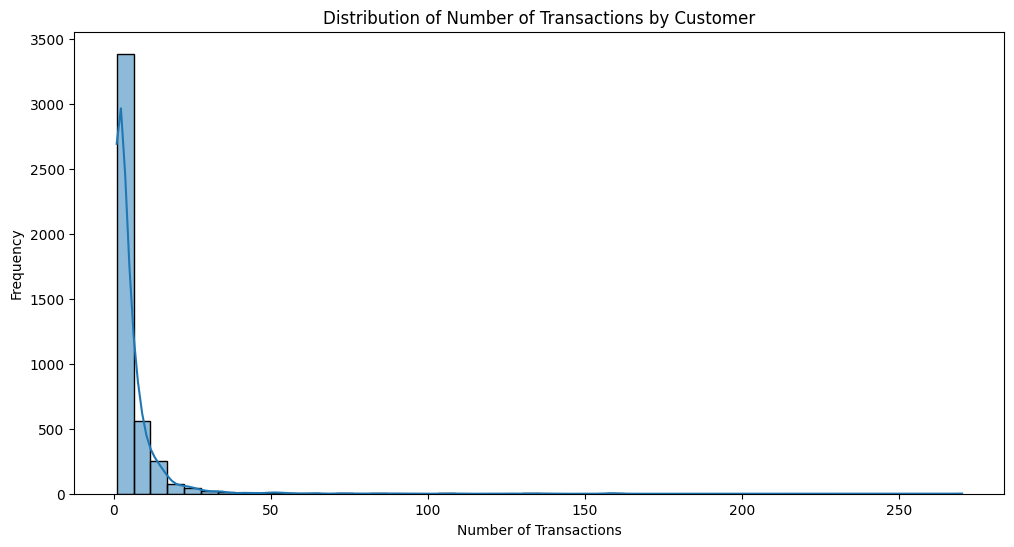

In [17]:
# Plot Number of Transactions Distribution
transaction_counts_by_customer = df.groupby('Customer ID')['Invoice'].nunique()
plt.figure(figsize=(12, 6))
sns.histplot(transaction_counts_by_customer, bins=50, kde=True)
plt.title('Distribution of Number of Transactions by Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

----------------------------------
---------------------------------------

# Recency Analysis

In [18]:
# Calculate Recency of Purchases
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
latest_purchase_date = df['InvoiceDate'].max()
df['Recency'] = (latest_purchase_date - df['InvoiceDate']).dt.days

* ### What is the average time since the last purchase for our customers?

In [19]:
# Calculate the latest purchase date
latest_purchase_date = df['InvoiceDate'].max()

# Calculate average recency
average_recency = df.groupby('Customer ID')['Recency'].min().mean()

print(f"Average time since the last purchase for all customers: {average_recency:.2f} days")

Average time since the last purchase for all customers: 90.40 days


* ### How do recent buyers (e.g., those who purchased within the last 30 days) differ from older buyers in terms of frequency and monetary value?

In [20]:
# Define what is considered a recent purchase
recent_threshold = 30

# Calculate total sales and number of transactions for recent and older buyers
recent_buyers = df[df['Recency'] <= recent_threshold]
older_buyers = df[df['Recency'] > recent_threshold]

# Aggregate metrics for recent buyers
recent_sales = recent_buyers.groupby('Customer ID').agg({
    'Total Amount': 'sum',
    'Invoice': 'nunique'
}).rename(columns={'Total Amount': 'TotalSalesRecent', 'Invoice': 'NumTransactionsRecent'})

# Aggregate metrics for older buyers
older_sales = older_buyers.groupby('Customer ID').agg({
    'Total Amount': 'sum',
    'Invoice': 'nunique'
}).rename(columns={'Total Amount': 'TotalSalesOlder', 'Invoice': 'NumTransactionsOlder'})

# Combine recent and older metrics
comparison_df = pd.concat([recent_sales, older_sales], axis=1)

# Calculate averages
average_recent_sales = comparison_df['TotalSalesRecent'].mean()
average_older_sales = comparison_df['TotalSalesOlder'].mean()
average_recent_transactions = comparison_df['NumTransactionsRecent'].mean()
average_older_transactions = comparison_df['NumTransactionsOlder'].mean()

print(f"Average total sales for recent buyers: £{average_recent_sales:.2f}")
print(f"Average total sales for older buyers: £{average_older_sales:.2f}")
print(f"Average number of transactions for recent buyers: {average_recent_transactions:.2f}")
print(f"Average number of transactions for older buyers: {average_older_transactions:.2f}")

Average total sales for recent buyers: £731.68
Average total sales for older buyers: £1974.55
Average number of transactions for recent buyers: 1.99
Average number of transactions for older buyers: 4.94


* ### How many unique customers are there in the dataset, and what percentage of them have made recent purchases?

In [21]:
# Define what is considered a recent purchase (e.g., within the last 30 days)
recent_threshold = 30

# Get the unique customers
unique_customers = df['Customer ID'].nunique()

# Identify customers with recent purchases
recent_customers = df[df['Recency'] <= recent_threshold]['Customer ID'].nunique()

# Calculate the percentage of customers with recent purchases
percentage_recent_customers = (recent_customers / unique_customers) * 100

print(f"Total number of unique customers: {unique_customers}")
print(f"Number of customers with recent purchases: {recent_customers}")
print(f"Percentage of customers with recent purchases: {percentage_recent_customers:.2f}%")

Total number of unique customers: 4383
Number of customers with recent purchases: 1673
Percentage of customers with recent purchases: 38.17%


* ### Are there seasonal trends in customer purchases, and how does this affect recency scores?

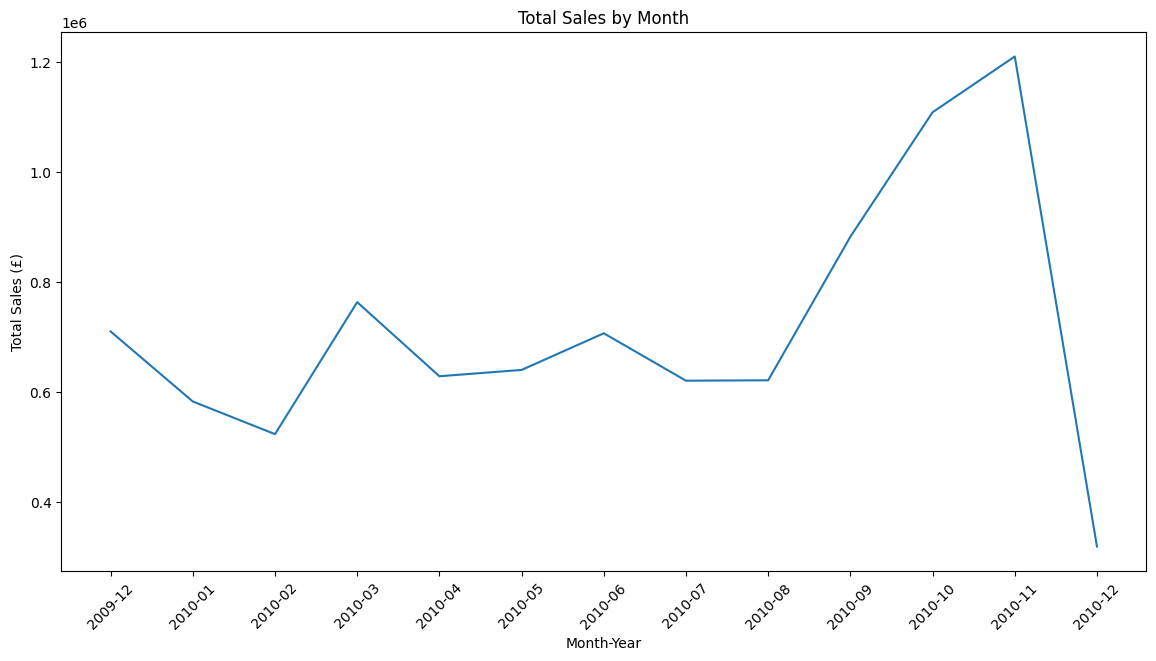

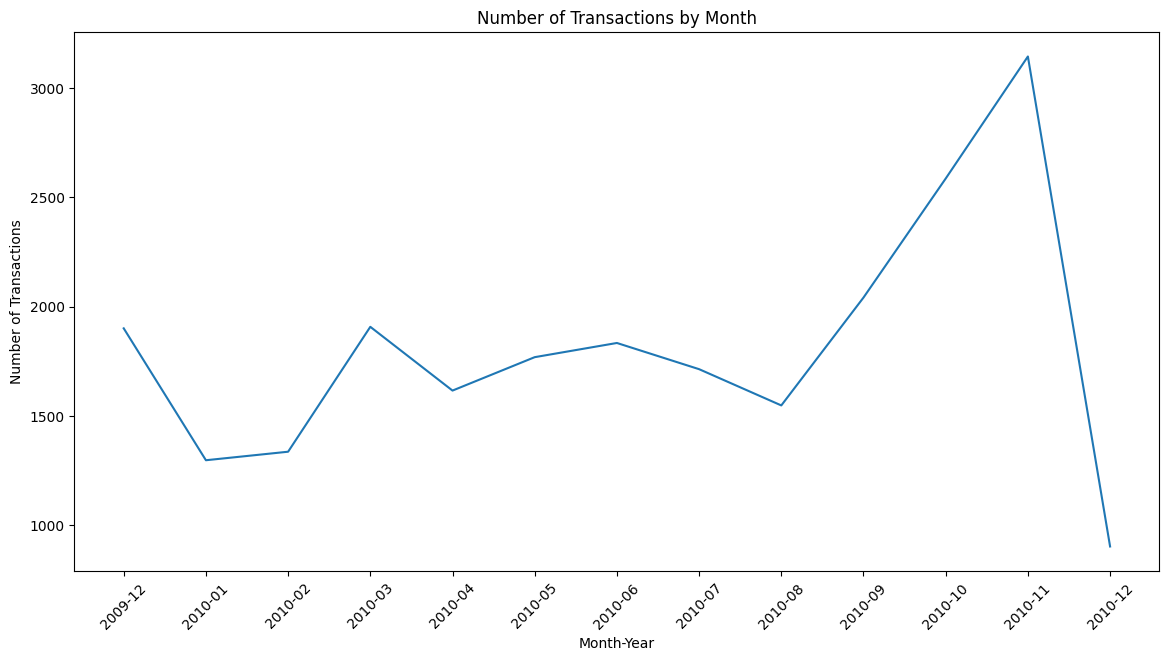

In [22]:
# Extract month and year from the InvoiceDate
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')

# Aggregate total sales and number of transactions by month-year
monthly_sales = df.groupby('MonthYear')['Total Amount'].sum()
monthly_transactions = df.groupby('MonthYear')['Invoice'].nunique()

# Plot total sales by month
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_sales.index.astype(str), y=monthly_sales.values)
plt.title('Total Sales by Month')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.show()

# Plot number of transactions by month
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_transactions.index.astype(str), y=monthly_transactions.values)
plt.title('Number of Transactions by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

------------------------
--------------------

# Frequency Analysis:

In [23]:
# Calculate the number of transactions (purchase frequency) per customer
purchase_frequency = df.groupby('Customer ID')['Invoice'].nunique()

* ### What is the distribution of purchase frequency across customers (e.g., one-time buyers vs. repeat buyers)?

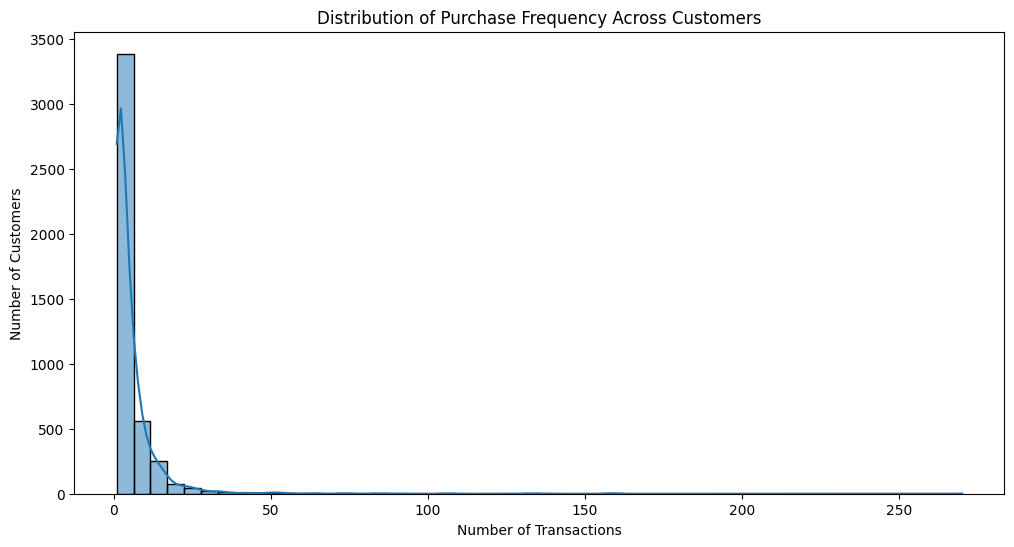

In [24]:
# Plot the distribution of purchase frequency
plt.figure(figsize=(12, 6))
sns.histplot(purchase_frequency, bins=50, kde=True)
plt.title('Distribution of Purchase Frequency Across Customers')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [25]:
# Identify one-time buyers and repeat buyers
one_time_buyers = purchase_frequency[purchase_frequency == 1].count()
repeat_buyers = purchase_frequency[purchase_frequency > 1].count()

print(f"Number of one-time buyers: {one_time_buyers}")
print(f"Number of repeat buyers: {repeat_buyers}")

Number of one-time buyers: 1267
Number of repeat buyers: 3116


* ### Which customer segments have the highest repeat purchase rates, and what products are they buying most often?

In [26]:
purchase_frequency = purchase_frequency.reset_index()
purchase_frequency.rename(columns={'Invoice':"Frequency"}, inplace = True)
purchase_frequency

,Customer ID,Frequency
0,12346.0,15
1,12347.0,2
2,12348.0,1
3,12349.0,4
4,12351.0,1
...,...,...
4378,18283.0,6
4379,18284.0,2
4380,18285.0,1
4381,18286.0,3


In [27]:
# Define a function to assign segments based on invoice count
def segment_customer(invoice):
    if invoice == 1:
        return '1-time'
    elif 2 <= invoice <= 3:
        return '2-3 times'
    elif 4 <= invoice <= 5:
        return '4-5 times'
    elif 6 <= invoice <= 10:
        return '6-10 times'
    else:
        return '10+ times'

# Apply the function to create a new column 'Segment'
purchase_frequency['Segment'] = purchase_frequency['Frequency'].apply(segment_customer)

In [28]:
# Group by 'Segment' and count the number of customers in each segment
segment_counts = purchase_frequency['Segment'].value_counts()

# Display the results
segment_counts

1-time        1267
2-3 times     1259
6-10 times     716
4-5 times      639
10+ times      502
Name: Segment, dtype: int64

* ### Which products bought by repeat customers?

In [29]:
purchase_frequency.head()

,Customer ID,Frequency,Segment
0,12346.0,15,10+ times
1,12347.0,2,2-3 times
2,12348.0,1,1-time
3,12349.0,4,4-5 times
4,12351.0,1,1-time


In [30]:
# Find the products most frequently bought by repeat customers
# Identify repeat customers (those with more than one invoice)
repeat_customers = purchase_frequency[purchase_frequency['Frequency'] > 1]

repeat_customers = pd.merge(repeat_customers, df, on='Customer ID')

repeat_customers

,Customer ID,Frequency,Segment,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Transaction Type,Total Amount,Recency,MonthYear
0,12346.0,15,10+ times,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,United Kingdom,Sale,45.0,360,2009-12
1,12346.0,15,10+ times,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,United Kingdom,Sale,22.5,360,2009-12
2,12346.0,15,10+ times,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,United Kingdom,Sale,22.5,360,2009-12
3,12346.0,15,10+ times,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,United Kingdom,Sale,22.5,356,2009-12
4,12346.0,15,10+ times,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,United Kingdom,Sale,1.0,356,2009-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390904,18287.0,5,4-5 times,534346,22866,HAND WARMER SCOTTY DOG DESIGN,12,2010-11-22 11:51:00,2.10,United Kingdom,Sale,25.2,17,2010-11
390905,18287.0,5,4-5 times,534346,85039A,SET/4 RED MINI ROSE CANDLE IN BOWL,48,2010-11-22 11:51:00,1.45,United Kingdom,Sale,69.6,17,2010-11
390906,18287.0,5,4-5 times,534346,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,48,2010-11-22 11:51:00,1.45,United Kingdom,Sale,69.6,17,2010-11
390907,18287.0,5,4-5 times,534346,85040A,S/4 PINK FLOWER CANDLES IN BOWL,48,2010-11-22 11:51:00,1.45,United Kingdom,Sale,69.6,17,2010-11


In [31]:
products_bought_by_repeat_customers = repeat_customers[['StockCode','Description']].value_counts().reset_index(name='PurchaseCount')
top_products = products_bought_by_repeat_customers .sort_values(by='PurchaseCount', ascending=False).head(10)

print("Top 10 products bought by repeat customers:")
top_products

Top 10 products bought by repeat customers:


,StockCode,Description,PurchaseCount
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3082
1,22423,REGENCY CAKESTAND 3 TIER,1793
2,21232,STRAWBERRY CERAMIC TRINKET BOX,1481
3,84879,ASSORTED COLOUR BIRD ORNAMENT,1307
4,21754,HOME BUILDING BLOCK WORD,1171
5,21212,PACK OF 72 RETRO SPOT CAKE CASES,1163
6,84991,60 TEATIME FAIRY CAKE CASES,1122
7,20725,LUNCH BAG RED SPOTTY,1086
8,21034,REX CASH+CARRY JUMBO SHOPPER,1082
9,85099B,JUMBO BAG RED RETROSPOT,1074


# Monetary Value Analysis:

* ### What is the average monetary value of a transaction, and how does it vary by customer segment?

In [32]:
# Calculate the average monetary value of a transaction
average_transaction_value = df['Total Amount'].mean()

print(f"Average monetary value of a transaction: £{average_transaction_value:.2f}")

Average monetary value of a transaction: £22.31


* ### Which customers contribute the most to our total revenue, and are they also the most frequent buyers?

In [33]:
total_revenue_per_customer = repeat_customers.groupby('Customer ID')['Total Amount'].sum()
top_revenue_contributors = total_revenue_per_customer.sort_values(ascending=False)

# Step 3: Compare with purchase frequency
frequency_data = purchase_frequency.set_index('Customer ID')['Frequency']

# Merge the total revenue and frequency data
revenue_and_frequency = pd.DataFrame({
    'Total Revenue': top_revenue_contributors,
    'Purchase Frequency': frequency_data
})

# Sort by revenue to identify patterns
revenue_and_frequency_sorted = revenue_and_frequency.sort_values(by='Total Revenue', ascending=False)

# Display the result
revenue_and_frequency_sorted.head(10)

,Total Revenue,Purchase Frequency
Customer ID,,
18102.0,356551.97,95
14646.0,252939.95,87
14156.0,209952.93,138
14911.0,166619.23,270
13694.0,134713.96,105
16684.0,85368.25,34
17511.0,85321.74,42
15061.0,84406.02,90
16754.0,76441.96,35


* ### Are there specific products  driving higher monetary values among top customers?

In [34]:
# Consider the top 3 customers for this analysis (or any other threshold you define)
top_customers = total_revenue_per_customer.sort_values(ascending=False).head(10).index

# Step 2: Filter data to include only top customers
top_customers_data = df[df['Customer ID'].isin(top_customers)]
revenue_per_product = top_customers_data.groupby(['StockCode','Description'])['Total Amount'].sum().reset_index()

# Step 4: Display the results
print("Revenue Contribution per Product among Top Customers:")
revenue_per_product.sort_values(by='Total Amount', ascending=False).head(10)

Revenue Contribution per Product among Top Customers:


,StockCode,Description,Total Amount
2681,M,Manual,57018.58
1274,22423,REGENCY CAKESTAND 3 TIER,45443.55
2579,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17631.72
637,21623,VINTAGE UNION JACK MEMOBOARD,16689.84
1057,22188,BLACK HEART CARD HOLDER,14464.28
1892,82484,WOOD BLACK BOARD ANT WHITE FINISH,13950.78
1058,22189,CREAM HEART CARD HOLDER,13898.80
2117,15056BL,EDWARDIAN PARASOL BLACK,10770.90
2118,15056N,EDWARDIAN PARASOL NATURAL,9975.00
2003,84879,ASSORTED COLOUR BIRD ORNAMENT,9636.08


----------------------------
---------------------------

# RFM Score

In [35]:
# Calculate Recency (days since last purchase)
latest_purchase_date = df['InvoiceDate'].max()
rfm_recency = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
rfm_recency['Recency'] = (latest_purchase_date - rfm_recency['InvoiceDate']).dt.days

# Calculate Frequency (number of transactions)
rfm_frequency = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
rfm_frequency.columns = ['Customer ID', 'Frequency']

# Calculate Monetary (total spending)
rfm_monetary = df.groupby('Customer ID')['Total Amount'].sum().reset_index()
rfm_monetary.columns = ['Customer ID', 'Monetary']


In [36]:
# Combine RFM metrics into one table
rfm_table = rfm_recency.merge(rfm_frequency, on='Customer ID').merge(rfm_monetary, on='Customer ID')

print("RFM Table:")
rfm_table.head()

RFM Table:


,Customer ID,InvoiceDate,Recency,Frequency,Monetary
0,12346.0,2010-10-04 16:33:00,66,15,810.40
1,12347.0,2010-12-07 14:57:00,2,2,1323.32
2,12348.0,2010-09-27 14:59:00,73,1,222.16
3,12349.0,2010-10-28 08:23:00,42,4,2695.29
4,12351.0,2010-11-29 15:23:00,10,1,300.93


In [37]:
# Define scoring functions for RFM metrics (1 to 5 scale)
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Calculate the overall RFM score (concatenation of R, F, M scores)
rfm_table['RFM_Score'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)

print("RFM Table with Scores:")
rfm_table.head()


RFM Table with Scores:


,Customer ID,InvoiceDate,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,2010-10-04 16:33:00,66,15,810.40,3,5,3,353
1,12347.0,2010-12-07 14:57:00,2,2,1323.32,5,2,4,524
2,12348.0,2010-09-27 14:59:00,73,1,222.16,2,1,1,211
3,12349.0,2010-10-28 08:23:00,42,4,2695.29,3,3,5,335
4,12351.0,2010-11-29 15:23:00,10,1,300.93,5,1,2,512


In [38]:
# Define RFM segments
def rfm_segment(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'Champions'
    elif row['R_Score'] == 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return 'Needing Attention'
    else:
        return 'At Risk'

# Apply segmentation
rfm_table['Segment'] = rfm_table.apply(rfm_segment, axis=1)

print("RFM Table with Segments:")
rfm_table.head()


RFM Table with Segments:


,Customer ID,InvoiceDate,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,2010-10-04 16:33:00,66,15,810.40,3,5,3,353,Potential Loyalists
1,12347.0,2010-12-07 14:57:00,2,2,1323.32,5,2,4,524,Needing Attention
2,12348.0,2010-09-27 14:59:00,73,1,222.16,2,1,1,211,At Risk
3,12349.0,2010-10-28 08:23:00,42,4,2695.29,3,3,5,335,Potential Loyalists
4,12351.0,2010-11-29 15:23:00,10,1,300.93,5,1,2,512,At Risk


In [39]:
rfm_table.drop(['InvoiceDate'],axis=1,inplace=True)

In [40]:
rfm_table.to_csv(r"D:\Portfolio Github\customer_purchase_behavior\rfm_score_segment.csv")

In [41]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_counts = rfm_table['Segment'].value_counts()

C:\Users\SHUCHISMITA MALLICK\AppData\Local\Temp\ipykernel_17048\426550633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


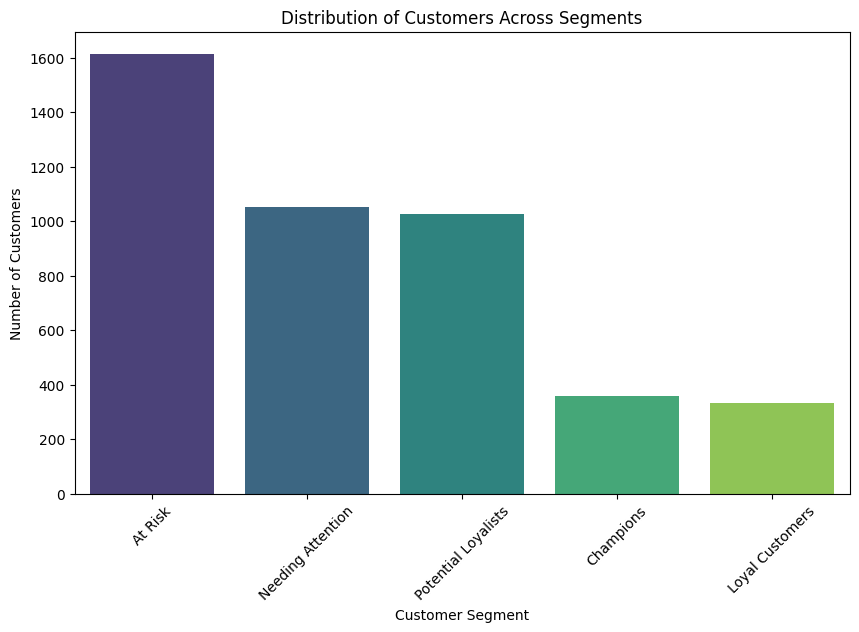

In [42]:

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Distribution of Customers Across Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


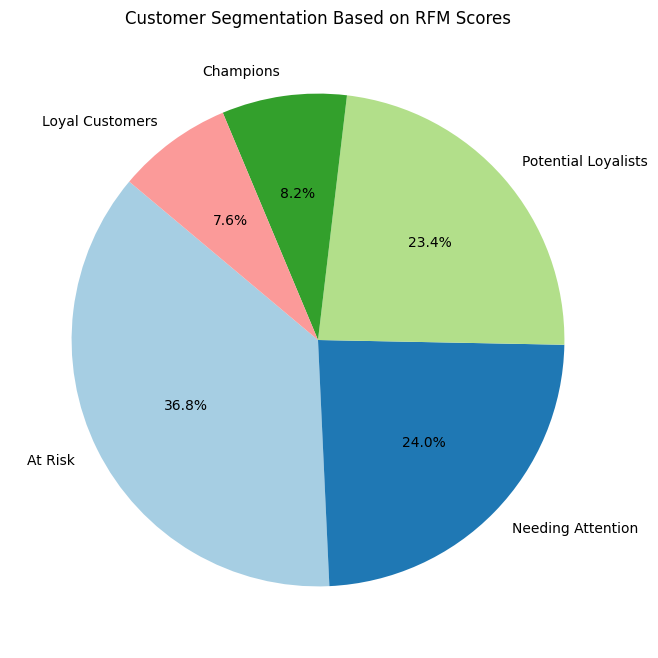

In [43]:
# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segmentation Based on RFM Scores')
plt.show()


## **Conclusion:**
* **At-Risk Customers:** A significant portion of the customer base (36.8%) falls into the "At Risk" segment, indicating they haven't made recent purchases. This presents a threat to long-term revenue if they churn.
* **Needing Attention:** 24% of customers are in the "Needing Attention" segment, suggesting they might soon slip into the at-risk category if not engaged properly.
* **Potential Loyalists:** 23.4% of the customer base shows potential for loyalty but may need nurturing to convert into "Champions."
* **Champions and Loyal Customers:** Together, these high-value customers (15.8%) contribute significantly to revenue and are likely to be retained with proper engagement.

### **Recommendations:**

#### Re-engagement Campaigns:
- **At-Risk Customers**: Implement targeted reactivation strategies such as personalized offers, discounts, or loyalty rewards to win back these customers.
- **Needing Attention**: Preemptively engage with these customers through follow-up emails and product recommendations to prevent them from becoming at risk.

#### Nurturing Potential Loyalists:
- Offer exclusive perks or early access to new products to convert these customers into loyalists or champions.

#### Retention Strategy for Top Customers:
- For "Champions" and "Loyal Customers," focus on personalized experiences and premium services to maintain their loyalty and encourage advocacy.

#### Product-Specific Promotions:
- Analyze the specific products that attract different segments and tailor marketing campaigns to highlight these items, especially for segments with lower monetary scores.

#### Seasonal Campaigns:
- Identify seasonal trends and use them to your advantage by launching timely promotions and reminders, particularly for customers with lower recency scores.


-------------------
----------------